In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import particlesim.api
import particlesim.helpers_for_tests
import particlesim.utils.xyz
import particlesim.utils.config_parser
import particlesim.utils.conversion

from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot_nacl(traj,left,right,num_na,traj_sample = -1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    last_na_pos = traj[traj_sample,:num_na,:]
    last_cl_pos = traj[traj_sample,num_na:,:]
    
    a =(last_na_pos <= right)*(last_na_pos >=left)
    a = a[:,0]*a[:,1]*a[:,2]
    small_box_na = last_na_pos[a]
    b = (last_cl_pos <= right)*(last_cl_pos >=left)
    b = b[:,0]*b[:,1]*b[:,2]
    
    small_box_cl = last_cl_pos[b]
    ax.scatter(small_box_na[:,0],small_box_na[:,1],small_box_na[:,2],c='r')
    ax.scatter(small_box_cl[:,0],small_box_cl[:,1],small_box_cl[:,2],c='b')
    ax.set_xlim([left,right])
    ax.set_ylim([left,right])
    ax.set_zlim([left,right])

In [3]:
def plot_systemconfig(system_config):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    num_na = len(system_config.xyz)//2
    ax.scatter(system_config.xyz[:num_na,0],system_config.xyz[:num_na,1],system_config.xyz[:num_na,2],c='r')
    ax.scatter(system_config.xyz[num_na:,0],system_config.xyz[num_na:,1],system_config.xyz[num_na:,2],c='b')
    ax.set_xlim([0,system_config.box_size])
    ax.set_ylim([0,system_config.box_size])
    ax.set_zlim([0,system_config.box_size])

In [5]:
def beta_fct(beta_start, beta_end, iteration_number):
    x = np.linspace(0,np.pi,iteration_number)
    beta = (beta_end - beta_start)*np.exp(-x)*(0.8+0.2*np.cos(15*x)) + beta_start
    return beta[::-1]


def multiple_beta(beta_list,iteration_list, linspace=False):
    beta=np.asarray([])
    if linspace:
        for i in range(len(beta_list)):
            beta = np.append(beta, 1.0 / np.linspace(1.0 / beta_list[i][1], 1.0 / beta_list[i][0], iteration_list[i])[::-1])
    else:
        for i in range(len(beta_list)):
            beta = np.append(beta,beta_fct(beta_list[i][0], beta_list[i][1], iteration_list[i]))
    return beta

def plot_beta(beta, T=False):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if T:
        temp = particlesim.utils.conversion.beta_to_kelvin(beta)
        ax1.plot(temp,linestyle = 'dashed',c='r',label="T")
        ax1.set_ylabel(r"$T$ [K]", fontsize = 20)
        ax1.legend(loc=2)
        ax = ax1.twinx()
        ax.plot(beta,'+',label="beta")
        ax.set_ylabel(r"$\beta$ [mol/kcal]", fontsize = 20)
        ax.set_xlabel(r"Iteration", fontsize = 20)
        ax.legend()
    else:
        ax1.plot(beta,'+',label="beta")
        ax1.set_ylabel(r"$\beta$ [mol/kcal]", fontsize = 20)
        ax1.set_xlabel(r"Iteration", fontsize = 20)
        ax1.legend()


## Config File:



[general]
box-size = 12

[particle_class_1]
label = Natrium
type = Na
charge = 1
distribution = uniform
number = 100

[particle_class_2]
label = Chlor
type = Cl
charge = -1
distribution = uniform
number = 100


### Generate system configuration from cfg-file with "problem creator" and a related sampler

In [6]:
creator = particlesim.utils.config_parser.ProblemCreator("config/600_particle_nacl_rand.cfg")

In [7]:
system_config = creator.generate_problem()

<IPython.core.display.Javascript object>


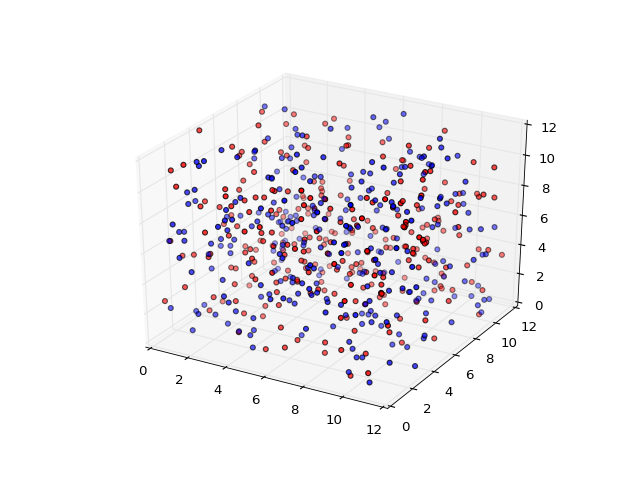

In [8]:
plot_systemconfig(system_config)

In [9]:
sampler = particlesim.api.Sampler(system_config)

#### Global parameter for simulated annealing

In [155]:
iteration_number = 60000
step = 0.0005
beta = [0.3,25]

#### Call metropolis simulated annealing function from sampler

In [148]:
system_config.xyz = traj[-1]

In [149]:
%%time
traj,pot = sampler.metropolis_sa(iteration_number=iteration_number, step=step, beta=beta)

CPU times: user 9min 8s, sys: 216 ms, total: 9min 9s
Wall time: 9min 9s


<IPython.core.display.Javascript object>


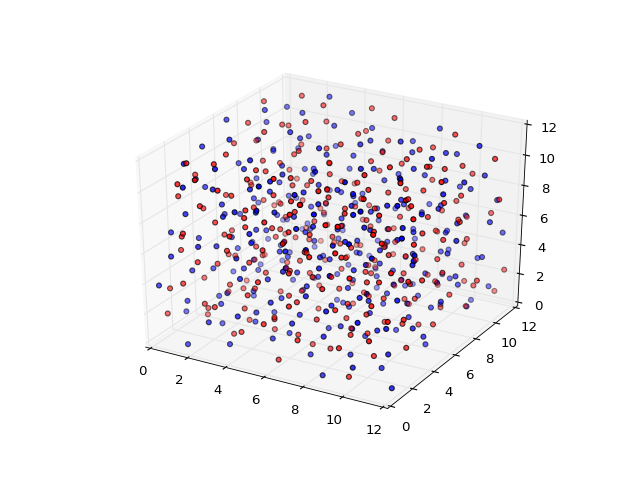

In [150]:
plot_nacl(traj=traj,left=0,right=12,num_na=300,traj_sample=-1)

In [151]:
beta_values = 1.0 / np.linspace(1.0 / beta[1], 1.0 / beta[0], iteration_number)[
    ::-1]

<IPython.core.display.Javascript object>


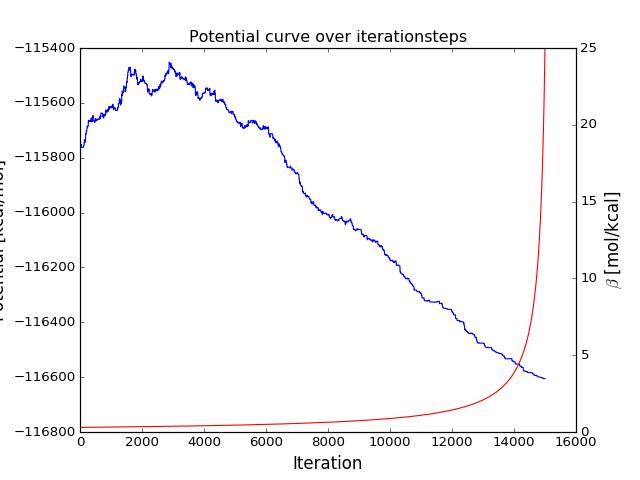

-116605.495744


In [152]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pot)
ax.set_xlabel(r"Iteration", fontsize=15)
ax.set_ylabel(r"Potential [kcal/mol]", fontsize=15)
#ax.set_ylim([-57000,-55000])
ax2 = ax.twinx()
ax2.plot(beta_values,c='r')
ax2.set_ylabel(r"$\beta$ [mol/kcal]",fontsize=15)
ax.set_title('Potential curve over iterationsteps')
print(pot[-1])

<IPython.core.display.Javascript object>


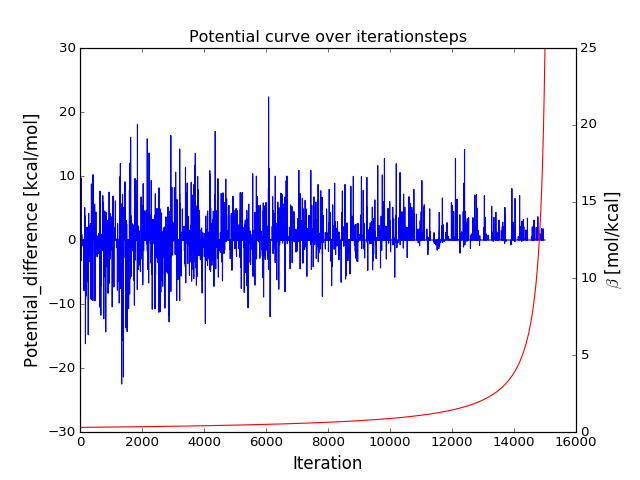

-116605.495744


In [156]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pot[:-1]-pot[1:])
ax.set_xlabel(r"Iteration", fontsize=15)
ax.set_ylabel(r"Potential_difference [kcal/mol]", fontsize=15)
ax2 = ax.twinx()
ax2.plot(beta_values,c='r')
ax2.set_ylabel(r"$\beta$ [mol/kcal]",fontsize=15)
ax.set_title('Potential curve over iterationsteps')
print(pot[-1])

In [157]:
traj_small = []
for i in range(0,traj.shape[0], 10):
    traj_small.append(traj[i,:])
traj_small = np.array(traj_small)
particlesim.utils.xyz.export_trajectory(labels=system_config.labels, trajectory=traj_small, 
                                        path='../../vmd_traj/600_part.xyz')

In [66]:
particlesim.utils.xyz.export_trajectory(labels=system_config.labels, trajectory=traj, 
                                        path='../../vmd_traj/600_part.xyz')

<IPython.core.display.Javascript object>


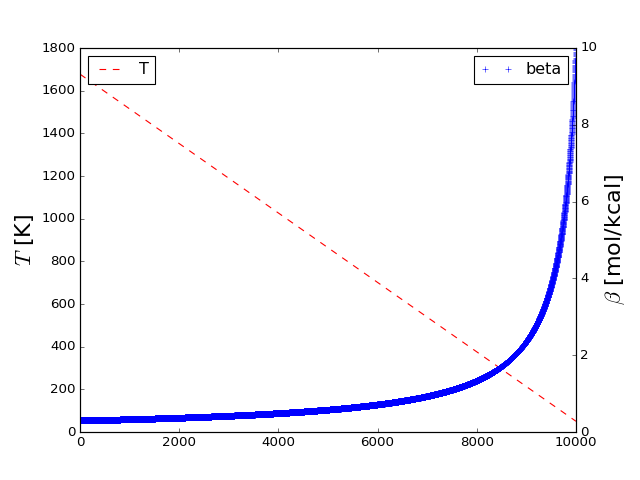

In [175]:
plot_beta(beta_values,T=True)

#### create beta values for double simulated annealing of system configuration

<IPython.core.display.Javascript object>


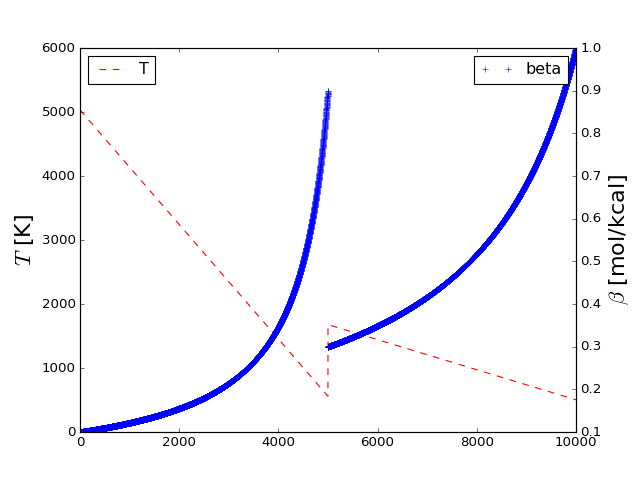

In [93]:
beta_list=[[0.1,0.9]]+[[0.3,1.]]
iter_list=[iteration_number//2,iteration_number//2]
#beta_list=[beta]
#iter_list= [iteration_number]
beta_many = multiple_beta(beta_list,iter_list, linspace=True)
plot_beta(beta_many,T=True)

In [94]:
%%time
traj_many, pot_many = sampler.metropolis_sa(iteration_number=iteration_number,step=0.01,beta=beta_many)

CPU times: user 3min 53s, sys: 40 ms, total: 3min 53s
Wall time: 3min 53s


<IPython.core.display.Javascript object>


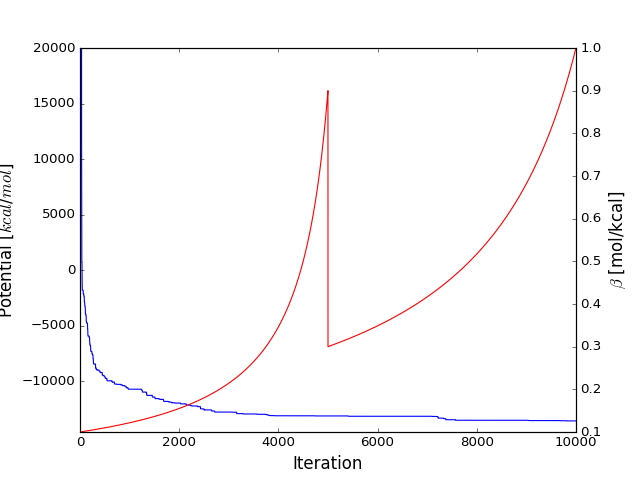

-13576.9196495


In [138]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pot_many)
ax.set_xlabel(r"Iteration", fontsize=15)
ax.set_ylabel(r"Potential [$kcal$/$mol$]", fontsize=15)
ax.set_ylim([pot_many[-1]-1000,20000])
ax2 = ax.twinx()
ax2.plot(beta_many,c='r')
ax2.set_ylabel(r"$\beta$ [mol/kcal]",fontsize=15)
print(pot_many[-1])

<IPython.core.display.Javascript object>


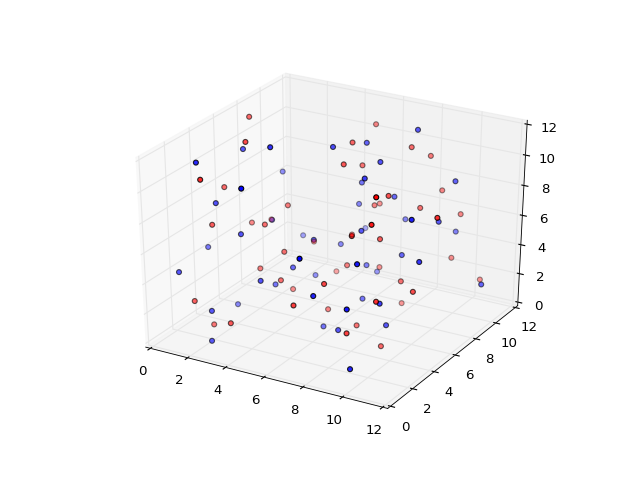

In [98]:
plot_nacl(traj=traj_many,left=0,right=12,num_na=50,traj_sample=-1)

In [56]:
system_config_mc = creator.generate_problem()

In [57]:
system_config_mc.xyz = traj[-1]

In [58]:
sampler_mc = particlesim.api.Sampler(system_config_mc)

#### Do plain metropolis monte carlo with last configuration from simulated annealing with three different temperatures
* T_1 = 200 Kelvin
* T_2 = 800 Kelvin
* T_3 = 1200 Kelvin

In [59]:
%%time
beta_mc = particlesim.utils.conversion.kelvin_to_beta(200)
iteration_mc = 2500
step_mc = 0.001
traj_mc_200, pot_mc_200 = sampler_mc.metropolis(iteration_number=iteration_mc,step = step_mc, beta= beta_mc) 

beta_mc = particlesim.utils.conversion.kelvin_to_beta(800)
traj_mc_800, pot_mc_800 = sampler_mc.metropolis(iteration_number=iteration_mc,step = step_mc, beta= beta_mc) 

beta_mc = particlesim.utils.conversion.kelvin_to_beta(1200)
traj_mc_1200, pot_mc_1200 = sampler_mc.metropolis(iteration_number=iteration_mc,step = step_mc, beta= beta_mc)

CPU times: user 9min 11s, sys: 216 ms, total: 9min 11s
Wall time: 9min 11s


<IPython.core.display.Javascript object>


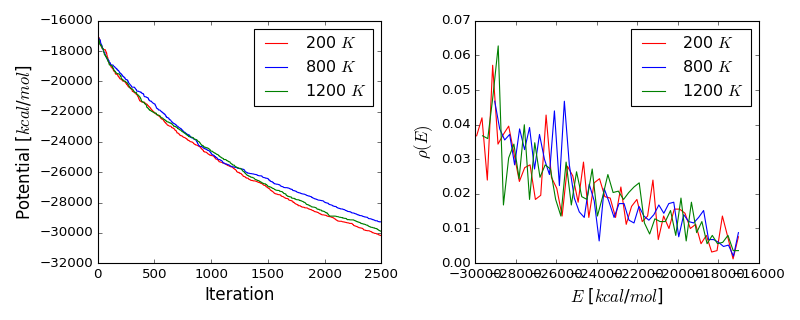

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#fig = plt.figure()
#ax = fig.add_subplot(111)
axes[0].plot(pot_mc_200, c='r', label = r"200 $K$")
axes[0].plot(pot_mc_800, c='b', label = r"800 $K$")
axes[0].plot(pot_mc_1200,c='g', label = r"1200 $K$")
axes[0].set_xlabel(r"Iteration", fontsize=15)
axes[0].set_ylabel(r"Potential [$kcal$/$mol$]", fontsize=15)
axes[0].legend()

#ax.set_ylim([pot_mc[-1]-200,0])

#ax2 = fig.add_subplot(222)
def create_hist(pot_mc):
    hist, edges = np.histogram(pot_mc, bins=50)
    rho = hist.astype(np.float64) / np.sum(hist)
    return edges,rho
edges200, rho200 = create_hist(pot_mc_200)
edges800, rho800 = create_hist(pot_mc_800)
edges1200, rho1200 = create_hist(pot_mc_1200)

axes[1].plot(edges200[1:], rho200, c='r', label = r"200 $K$")
axes[1].plot(edges800[1:], rho800, c='b', label = r"800 $K$")
axes[1].plot(edges1200[1:], rho1200, c='g', label = r"1200 $K$")

axes[1].set_xlabel(r"$E$ [$kcal$/$mol$]", fontsize=15)
axes[1].set_ylabel(r"$\rho(E)$", fontsize=15)
axes[1].legend()
fig.tight_layout()